In [98]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import Activation, Dropout
from keras.optimizers import Adam, RMSprop


In [99]:
# Download dataset from github
!npx degit pdhimate/machinelearning/face_mask/dataset/with_mask#2780ff3eb9116e19cb35c060b4c569013ba0cd25 -f with_mask
!npx degit pdhimate/machinelearning/face_mask/dataset/without_mask#2780ff3eb9116e19cb35c060b4c569013ba0cd25 -f without_mask


npx: installed 1 in 0.774s
> destination directory is not empty. Using --force, continuing
> cloned pdhimate/machinelearning#2780ff3eb9116e19cb35c060b4c569013ba0cd25 to with_mask
npx: installed 1 in 2.219s
> destination directory is not empty. Using --force, continuing
> cloned pdhimate/machinelearning#2780ff3eb9116e19cb35c060b4c569013ba0cd25 to without_mask


In [100]:
# Init variables and funcs
WITH_MASK_DIR = '/content/with_mask'
WITHOUT_MASK_DIR =  '/content/without_mask'
img_height, img_width = 64, 64

# Stores the entire dataset
dataset = []

def preprocess_dataset(dir, labels):
  for img in tqdm(os.listdir(dir)):
    path = os.path.join(dir, img)
    img = cv2.imread(path)
    img = cv2.resize(cv2.imread(path), (img_width, img_height))
    img = img/255
    dataset.append([np.array(img), np.array(labels)])

def plot_accuracy_loss(train_ac, val_ac, train_loss, val_loss):
  # Plot Epoch vs Accuracy metric values
  plt.plot(train_ac, label='training accuracy')
  plt.plot(val_ac, label = 'validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Plot Epoch vs loss values
  plt.plot(train_loss, label = 'training loss')
  plt.plot(val_loss, label = 'validation loss')
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


In [101]:
# preprocess and train test split
dataset = []
preprocess_dataset(WITH_MASK_DIR, [1,0])
preprocess_dataset(WITHOUT_MASK_DIR, [0,1])
dataset = np.array(dataset)
print(dataset.shape)
data = np.array([i[0] for i in dataset]).reshape(-1, img_height, img_width, 3)
labels = np.array([i[1] for i in dataset])#.reshape(-1, img_height, img_width, 3)
print(labels)

train_x, test_x, train_y, test_y = train_test_split(data,labels, test_size=0.25, random_state=42, stratify=labels)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


100%|██████████| 1850/1850 [00:03<00:00, 502.08it/s]


(3689, 2)
[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
(2766, 64, 64, 3)
(2766, 2)
(923, 64, 64, 3)
(923, 2)


In [102]:
def cnn_model():
  model = Sequential()

  model.add(Conv2D(32, (3,3), input_shape=train_x.shape[1:], activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

model = cnn_model()
model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 58, 58, 128)     

In [103]:
hist = model.fit(train_x, train_y, batch_size=32, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
70/70 [==============================] - 3s 46ms/step - loss: 0.6360 - accuracy: 0.8395 - val_loss: 0.2434 - val_accuracy: 0.9188
Epoch 2/20
70/70 [==============================] - 3s 43ms/step - loss: 0.2515 - accuracy: 0.9073 - val_loss: 0.1886 - val_accuracy: 0.9404
Epoch 3/20
70/70 [==============================] - 3s 43ms/step - loss: 0.2186 - accuracy: 0.9259 - val_loss: 0.2244 - val_accuracy: 0.9458
Epoch 4/20
70/70 [==============================] - 3s 43ms/step - loss: 0.2039 - accuracy: 0.9272 - val_loss: 0.1580 - val_accuracy: 0.9404
Epoch 5/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1448 - accuracy: 0.9458 - val_loss: 0.1083 - val_accuracy: 0.9531
Epoch 6/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1173 - accuracy: 0.9575 - val_loss: 0.1639 - val_accuracy: 0.9260
Epoch 7/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1320 - accuracy: 0.9525 - val_loss: 0.1508 - val_accuracy: 0.9422
Epoch 8/20
70

29/29 [==============================] - 0s 9ms/step - loss: 0.1386 - accuracy: 0.9599
[0.13857336342334747, 0.9599133133888245]


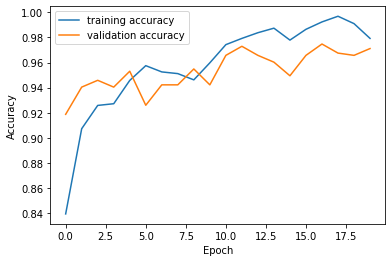

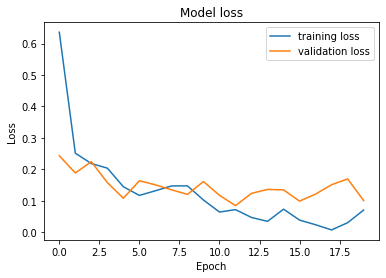

In [104]:
# Evaluate against unseen data
print(model.evaluate(test_x, test_y, verbose=1))

# plot performance
plot_accuracy_loss(hist.history['accuracy'], hist.history['val_accuracy'], hist.history['loss'], hist.history['val_loss'])


In [105]:
model.save("model.h5")